# Basic examples

In this notebook we will show how to run reconstruction on a mock, and compute the post-reconstruction power spectrum.

In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt

from pyrecon import MultiGridReconstruction, IterativeFFTReconstruction, PlaneParallelFFTReconstruction, utils, setup_logging
# For pypower installation, see https://pypower.readthedocs.io/en/latest/user/building.html
from pypower import CatalogFFTPower, PowerSpectrumStatistics

# Set up logging
setup_logging()

## Generate some mock for this notebook

In [2]:
from mockfactory import LagrangianLinearMock, RandomBoxCatalog, cartesian_to_sky, DistanceToRedshift
from cosmoprimo.fiducial import DESI

base_dir = os.path.join('_tests')
data_fn = os.path.join(base_dir, 'lognormal_data.fits')
randoms_fn = os.path.join(base_dir, 'lognormal_randoms.fits')
z, bias, nbar, nmesh, boxsize = 0.7, 2.0, 3e-4, 256, 800.
cosmo = DESI()
d2z = DistanceToRedshift(cosmo.comoving_radial_distance)
pklin = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
f = cosmo.sigma8_z(z=z, of='theta_cb') / cosmo.sigma8_z(z=z, of='delta_cb')  # growth rate
dist = cosmo.comoving_radial_distance(z)
boxcenter = [dist, 0, 0]
mock = LagrangianLinearMock(pklin, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=42, unitary_amplitude=False)
# this is Lagrangian bias, Eulerian bias - 1
mock.set_real_delta_field(bias=bias - 1)
mock.set_analytic_selection_function(nbar=nbar)
mock.poisson_sample(seed=43)
mock.set_rsd(f=f, los=None)
data = mock.to_catalog()

# We've got data, now turn to randoms
randoms = RandomBoxCatalog(nbar=10. * nbar, boxsize=boxsize, boxcenter=boxcenter, seed=44)
# Add columns to test pyrecon script
for cat in [data, randoms]:
    cat['Weight'] = cat.ones()
    cat['NZ'] = nbar * cat.ones()
    dist, cat['RA'], cat['DEC'] = cartesian_to_sky(cat['Position'])
    cat['Z'] = d2z(dist)

data.write(data_fn)
randoms.write(randoms_fn)

[000003.67]  12-13 18:48  LagrangianLinearMock         INFO     White noise generated.
[000006.03]  12-13 18:48  LagrangianLinearMock         INFO     Poisson sampling done, total number of objects is 154074.
[000007.37]  12-13 18:48  LagrangianLinearMock         INFO     Catalog produced. Assigning in cell shift.
[000007.86]  12-13 18:48  FileStack                    INFO     Writing _tests/lognormal_data.fits.
[000007.96]  12-13 18:48  FileStack                    INFO     Writing _tests/lognormal_randoms.fits.


## Run reconstruction

In [3]:
'''
# Read input catalogs, scattering on all MPI ranks (1 in this notebook)
def read(fn, columns=['Position'], ext=1):
    #import fitsio
    #gsize = fitsio.FITS(fn)[ext].get_nrows()
    #start, stop = mpicomm.rank * gsize // mpicomm.size, (mpicomm.rank + 1) * gsize // mpicomm.size
    #tmp = fitsio.read(fn, ext=ext, columns=[column], rows=range(start, stop))
    #return {column: tmp[column] for column in columns}
'''
# Here we just use mockfactory's Catalog that has read()
from mockfactory import Catalog

data = Catalog.read(data_fn)
randoms = Catalog.read(randoms_fn)

#ReconstructionAlgorithm = MultiGridReconstruction # choose your algorithm
ReconstructionAlgorithm = IterativeFFTReconstruction
#ReconstructionAlgorithm = PlaneParallelFFTReconstruction
# No need to provide randoms_positions and randoms_weights in case of periodic boundary conditions;
# in this case you may want to pass "wrap=False"
# los can be None (local) or any box axis ('x', 'y', 'z') or 3-vector
# Input positions, weights are assumed MPI-scattered as a default (what mockfactory's Catalog returns);
# If positions and weights are gathered on e.g. rank 0, pass mpiroot = 0
# position_type is 'pos' (default) because input positions are (N, 3); in case positions are (N3, N), pass position_type='xyz'
# weights can be ommitted if constant (1)
recon = ReconstructionAlgorithm(f=0.8, bias=2., los=None, data_positions=data['Position'], data_weights=data['Weight'],
                                randoms_positions=randoms['Position'], randoms_weights=randoms['Weight'], nmesh=128, boxsize=1200.,
                                fft_plan='estimate')

data['Position_rec'] = recon.read_shifted_positions(data['Position'], field='disp+rsd')
# RecSym = remove large scale RSD from randoms
# randoms['Position_rec'] = recon.read_shifted_positions(randoms['Position'], field='disp+rsd')
# or RecIso
randoms['Position_rec'] = recon.read_shifted_positions(randoms['Position'], field='disp')

[000009.18]  12-13 18:48  IterativeFFTReconstruction   INFO     Using mesh with nmesh=[128 128 128], boxsize=[1200. 1200. 1200.], boxcenter=[1.74249761e+03 1.18930163e-01 5.80369542e-02].
[000009.20]  12-13 18:48  IterativeFFTReconstruction   INFO     Slab 0 ~ 4194304 / 154074.
[000009.28]  12-13 18:48  IterativeFFTReconstruction   INFO     Painted 154074 out of 154074 objects to mesh.
[000009.34]  12-13 18:48  IterativeFFTReconstruction   INFO     Slab 0 ~ 4194304 / 1536000.
[000009.93]  12-13 18:48  IterativeFFTReconstruction   INFO     Painted 1536000 out of 1536000 objects to mesh.
[000010.22]  12-13 18:48  IterativeFFTReconstruction   INFO     Running iteration 0.
[000011.11]  12-13 18:48  IterativeFFTReconstruction   INFO     Running iteration 1.
[000012.06]  12-13 18:48  IterativeFFTReconstruction   INFO     Running iteration 2.


## Estimate power spectrum multipoles

[000015.14]  12-13 18:48  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[256 256 256], boxsize=[1400. 1400. 1400.], boxcenter=[1.74249761e+03 1.18930163e-01 5.80369542e-02], dtype=float64).
[000015.19]  12-13 18:48  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 154074.
[000015.27]  12-13 18:48  CatalogMesh                  INFO     Painted 154074 out of 154074 objects to mesh.
[000015.30]  12-13 18:48  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 1536000.
[000015.85]  12-13 18:48  CatalogMesh                  INFO     Painted 1536000 out of 1536000 objects to mesh.
[000015.86]  12-13 18:48  CatalogMesh                  INFO     Running interlacing at order 2.
[000016.15]  12-13 18:48  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 154074.
[000016.24]  12-13 18:48  CatalogMesh                  INFO     Painted 154074 out of 154074 objects to mesh.
[000016.26]  12-13 18:48  CatalogMesh                  INFO     Slab 0 

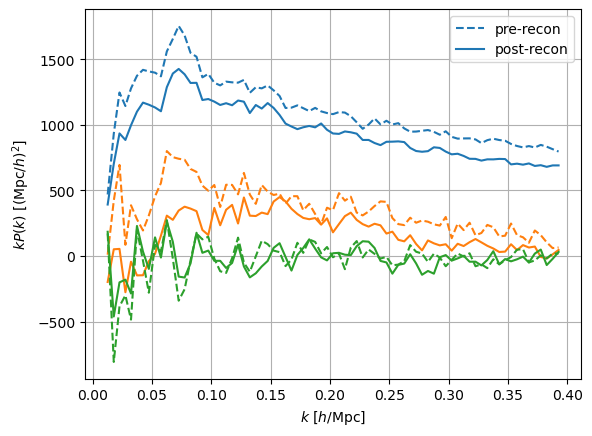

In [4]:
kedges = np.arange(0.01, 0.4, 0.005)

poles = CatalogFFTPower(data_positions1=data['Position'], data_weights1=data['Weight'],
                        randoms_positions1=randoms['Position'], randoms_weights1=randoms['Weight'],
                        boxsize=1400., nmesh=256, resampler='cic', interlacing=2, ells=(0, 2, 4),
                        los='firstpoint', edges=kedges, position_type='pos').poles

poles_recon = CatalogFFTPower(data_positions1=data['Position_rec'], data_weights1=data['Weight'],
                              randoms_positions1=randoms['Position'], randoms_weights1=randoms['Weight'],
                              shifted_positions1=randoms['Position_rec'], shifted_weights1=randoms['Weight'],
                              boxsize=1400., nmesh=256, resampler='cic', interlacing=2, ells=(0, 2, 4),
                              los='firstpoint', edges=kedges, position_type='pos').poles

ax = plt.gca()
for ill, ell in enumerate(poles.ells):
    ax.plot(poles.k, poles.k*poles(ell=ell, complex=False), color='C{:d}'.format(ill), linestyle='--', label='pre-recon' if ill == 0 else None)
    ax.plot(poles_recon.k, poles_recon.k*poles_recon(ell=ell, complex=False), color='C{:d}'.format(ill), linestyle='-', label='post-recon' if ill == 0 else None)
ax.legend()
ax.grid(True)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

## MPI
**pyrecon** and **pypower** are MPI-parallelized. Let's start from pre-recon catalogs saved on disk.

In [5]:
%%file '_tests/script.py'

import os

import numpy as np
from matplotlib import pyplot as plt

from pyrecon import MultiGridReconstruction, IterativeFFTReconstruction, PlaneParallelFFTReconstruction, setup_logging
# For pypower installation, see https://pypower.readthedocs.io/en/latest/user/building.html
from pypower import CatalogFFTPower

# Set up logging
setup_logging()

base_dir = os.path.join('_tests')
data_fn = os.path.join(base_dir, 'lognormal_data.fits')
randoms_fn = os.path.join(base_dir, 'lognormal_randoms.fits')

'''
# Read input catalogs, scattering on all MPI ranks (1 in this notebook)
def read(fn, columns=['Position'], ext=1):
    #import fitsio
    #gsize = fitsio.FITS(fn)[ext].get_nrows()
    #start, stop = mpicomm.rank * gsize // mpicomm.size, (mpicomm.rank + 1) * gsize // mpicomm.size
    #tmp = fitsio.read(fn, ext=ext, columns=[column], rows=range(start, stop))
    #return {column: tmp[column] for column in columns}
'''
# Here we just use mockfactory's Catalog that has read()
from mockfactory import Catalog

data = Catalog.read(data_fn)
randoms = Catalog.read(randoms_fn)

# First, run reconstruction
#ReconstructionAlgorithm = MultiGridReconstruction # choose your algorithm
ReconstructionAlgorithm = IterativeFFTReconstruction
#ReconstructionAlgorithm = PlaneParallelFFTReconstruction
recon = ReconstructionAlgorithm(f=0.8, bias=2., los=None, data_positions=data['Position'], data_weights=data['Weight'],
                                randoms_positions=randoms['Position'], randoms_weights=randoms['Weight'], nmesh=128, boxsize=1200.)

data['Position_rec'] = recon.read_shifted_positions(data['Position'], field='disp+rsd')
randoms['Position_rec'] = recon.read_shifted_positions(randoms['Position'], field='disp')

# Then, compute power spectrum
kedges = np.arange(0.01, 0.4, 0.005)
poles = CatalogFFTPower(data_positions1=data['Position'], data_weights1=data['Weight'],
                        randoms_positions1=randoms['Position'], randoms_weights1=randoms['Weight'],
                        boxsize=1400., nmesh=256, resampler='cic', interlacing=2, ells=(0, 2, 4),
                        los='firstpoint', edges=kedges, position_type='pos').poles
base_dir = '_tests'
fn = os.path.join(base_dir, 'poles.npy')
poles.save(fn)
poles_recon = CatalogFFTPower(data_positions1=data['Position_rec'], data_weights1=data['Weight'],
                              randoms_positions1=randoms['Position'], randoms_weights1=randoms['Weight'],
                              shifted_positions1=randoms['Position_rec'], shifted_weights1=randoms['Weight'],
                              boxsize=1400., nmesh=256, resampler='cic', interlacing=2, ells=(0, 2, 4),
                              los='firstpoint', edges=kedges, position_type='pos').poles
fn = os.path.join(base_dir, 'poles_recon.npy')
poles.save(fn)

Overwriting _tests/script.py


In [6]:
%%bash
mpiexec -np 4 python _tests/script.py

[000000.87]  12-13 18:49  IterativeFFTReconstruction   INFO     Using mesh with nmesh=[128 128 128], boxsize=[1200. 1200. 1200.], boxcenter=[1.74249761e+03 1.18930163e-01 5.80369542e-02].
[000000.89]  12-13 18:49  IterativeFFTReconstruction   INFO     Slab 0 ~ 4194304 / 154074.
[000000.96]  12-13 18:49  IterativeFFTReconstruction   INFO     Painted 154074 out of 154074 objects to mesh.
[000001.02]  12-13 18:49  IterativeFFTReconstruction   INFO     Slab 0 ~ 4194304 / 1536000.
[000001.50]  12-13 18:49  IterativeFFTReconstruction   INFO     Painted 1536000 out of 1536000 objects to mesh.
[000001.79]  12-13 18:49  IterativeFFTReconstruction   INFO     Running iteration 0.
[000002.64]  12-13 18:49  IterativeFFTReconstruction   INFO     Running iteration 1.
[000003.49]  12-13 18:49  IterativeFFTReconstruction   INFO     Running iteration 2.
[000006.39]  12-13 18:49  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[256 256 256], boxsize=[1400. 1400. 1400.],

In [7]:
!ls -l _tests

total 257844
-rw-r--r-- 1 adematti idphp    57053 déc.  13 18:30 correlator.npy
-rw-r--r-- 1 adematti idphp 72054720 déc.  13 18:29 data.fits
-rw-r--r-- 1 adematti idphp 32000128 déc.  13 18:29 initial_conditions.npy
-rw-r--r-- 1 adematti idphp 13564800 déc.  13 18:48 lognormal_data.fits
-rw-r--r-- 1 adematti idphp 98311680 déc.  13 18:48 lognormal_randoms.fits
-rw-r--r-- 1 adematti idphp    11005 déc.  13 18:49 poles.npy
-rw-r--r-- 1 adematti idphp    11005 déc.  13 18:49 poles_recon.npy
-rw-r--r-- 1 adematti idphp 48006720 déc.  13 18:29 randoms.fits
-rw-r--r-- 1 adematti idphp     2810 déc.  13 18:49 script.py


[000070.32]  12-13 18:49  PowerSpectrumStatistics      INFO     Loading _tests/poles.npy.
[000070.33]  12-13 18:49  PowerSpectrumStatistics      INFO     Loading _tests/poles_recon.npy.


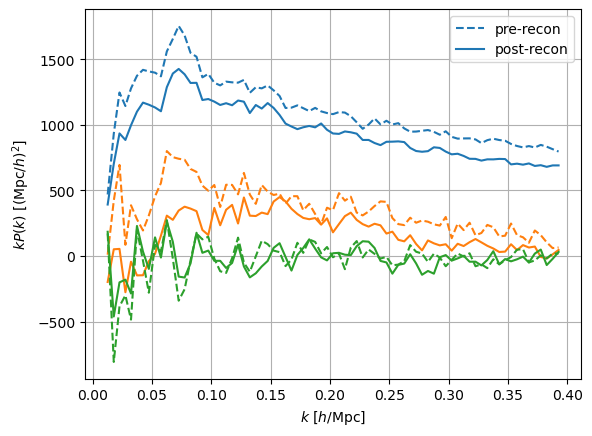

In [8]:
fn = os.path.join(base_dir, 'poles.npy')
poles = PowerSpectrumStatistics.load(fn)
fn = os.path.join(base_dir, 'poles_recon.npy')
poles = PowerSpectrumStatistics.load(fn)

ax = plt.gca()
for ill, ell in enumerate(poles.ells):
    ax.plot(poles.k, poles.k*poles(ell=ell, complex=False), color='C{:d}'.format(ill), linestyle='--', label='pre-recon' if ill == 0 else None)
    ax.plot(poles_recon.k, poles_recon.k*poles_recon(ell=ell, complex=False), color='C{:d}'.format(ill), linestyle='-', label='post-recon' if ill == 0 else None)
ax.legend()
ax.grid(True)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()